In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

plt.style.use("seaborn")

## Question 1: Maximum likelihood estimation of an increasing nonnegative signal 

### Translate Matlab data to python

In [2]:
# create problem data  
N = 100
# create an increasing input signal
xtrue = np.zeros((N, 1))
xtrue[0:40] = 0.1
xtrue[49] = 2
xtrue[69:80] = 0.15
xtrue[79] = 1
xtrue = np.cumsum(xtrue)

# pass the increasing input through a moving-average filter 
# and add Gaussian noise
h = np.array([1, -0.85, 0.7, -0.3])
k = len(h)
h, k
yhat = np.convolve(h, xtrue)
y = (
    yhat[:-3]
    + np.array([-0.43, -1.7, 0.13, 0.29, -1.1, 1.2, 1.2, -0.038, 0.33, 0.17, -0.19, 0.73, -0.59, 2.2, -0.14, 0.11, 1.1, 0.059, -0.096, -0.83, 0.29, -1.3, 0.71, 1.6, -0.69, 0.86, 1.3, -1.6, -1.4, 0.57, -0.4, 0.69, 0.82, 0.71, 1.3, 0.67, 1.2, -1.2, -0.02, -0.16, -1.6, 0.26, -1.1, 1.4, -0.81, 0.53, 0.22, -0.92, -2.2, -0.059, -1, 0.61, 0.51, 1.7, 0.59, -0.64, 0.38, -1, -0.02, -0.048, 4.3e-05, -0.32, 1.1, -1.9, 0.43, 0.9, 0.73, 0.58, 0.04, 0.68, 0.57, -0.26, -0.38, -0.3, -1.5, -0.23, 0.12, 0.31, 1.4, -0.35, 0.62, 0.8, 0.94, -0.99, 0.21, 0.24, -1, -0.74, 1.1, -0.13, 0.39, 0.088, -0.64, -0.56, 0.44, -0.95, 0.78, 0.57, -0.82, -0.27])
)
y = y.reshape(-1, 1)

## Run optimisation

In [3]:
x = cp.Variable((N, 1))

objective = cp.Minimize(cp.norm(y - cp.conv(h, x)[:-3]))

# Add constraint that the series is nonnegative and monotonically nondecreasing
constraints = [x >= 0, x[1:] - x[:-1] >= 0]

problem = cp.Problem(objective, constraints)

problem.solve()

7.681121976493933

In [4]:
x_unconstrained = cp.Variable((N, 1))

objective = cp.Minimize(cp.norm(y - cp.conv(h, x_unconstrained)[:-3]))

problem_unconstrained = cp.Problem(objective)

problem_unconstrained.solve()

-4.864729355754208e-12

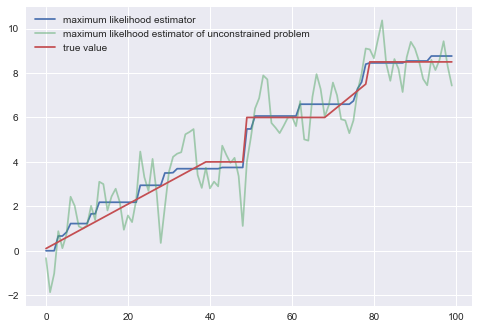

In [9]:
p = np.arange(100)
ax = plt.gca()
ax.plot(p, x.value, label="maximum likelihood estimator")
ax.plot(p, x_unconstrained.value, label="maximum likelhood estimator of unconstrained problem", alpha=0.5)
ax.plot(p, xtrue, label="true value")
ax.legend()

## Question 2: Worst-case probability of loss

We're considering the return of two investments, where we know that the marginal distribution of the return of each
is Gaussian, with given mean and standard deviation: $R_1 \sim \mathcal{N}(\mu_1, \sigma_1^2)$ and $R_2 \sim \mathcal{N}(\mu_2, \sigma_2^2)$, and correlated with coefficient $\rho$:

$$\mathbb{E}[(R_1 - \mu_1)(R_2 - \mu_2) = \rho\sigma_1\sigma_2$$

What's our chance of losing money? Ie what is $p^{loss} = \mathbb{P}(R_1 + R_2 \leq 0)$? For this we need the joint
distribution of the two variables. A naive answer is to consider the case when $R_1$ and $R_2$ are jointly Gaussian,
so we can easily see mean and standard deviation:

In [27]:
from scipy import stats

mu_1 = 8
mu_2 = 20
sigma_1 = 6
sigma_2 = 17.5
rho = -0.25

combined_mu = mu_1 + mu_2
combined_sigma = np.sqrt(sigma_1 ** 2 + sigma_2 ** 2 + 2 * rho * sigma_1 * sigma_2)

print(f"p^loss = {stats.norm(combined_mu, combined_sigma).cdf(0):.2f}")

p^loss = 0.05


But in other joint distributions, the chance of losing money could be much higher. We'll do an optimisation to 
find the _worst case_, ie the joint distribution that maximises $p^{loss}$ with the constraint that the marginals 
are as given.

In order to make the problem tractable, we discretize the distributions by taking 100 values between -30 and 70, 
calculating the shaped part of the Gaussian density (ie $exp(-\frac{x - \mu}{2\sigma^2})$) and normalizing it to sum
to 1 over the range. 

This defines a vector representing the marginal for each of $R_1$ and $R_2$. The joint distribution $R$ is then a 
matrix with the i-jth entry representing $\mathbb{P}(R_1 = r_i, R_2 = r_j)$, and the constraint that the marginals are 
as given is that the columns (and rows respectively) sum to give our vector for the marginal of $R_1$ (and for $R_2$
respectively). The constraint that they're correlated as expected is just given by
$(r - \mu_1)^T P (r - \mu_2) = \rho\sigma_1\sigma_2$ (since precomposing gives the expectation in the first variable, 
and post the expectation in the second variable). Finally, we add a constraint that the probability is always greater
than zero.

In [239]:
r = np.linspace(-30, 70, 100)
R_1 = np.exp(-(r - mu_1) ** 2 / (2 * sigma_1 ** 2))
R_1 /= R_1.sum()
R_2 = np.exp(-(r - mu_2) ** 2 / (2 * sigma_2 ** 2))
R_2 /= R_2.sum()

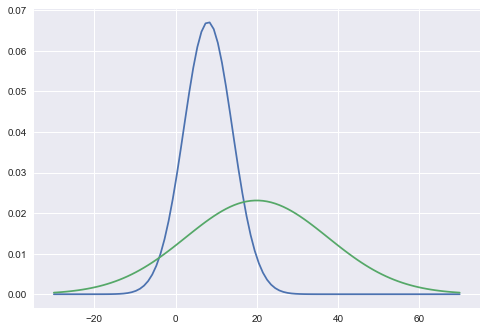

In [240]:
plt.plot(r, R_1)
plt.plot(r, R_2)

In [241]:
joint = cp.Variable((100, 100))

summed_variables = r.reshape(-1, 1) + r

objective = cp.Maximize(cp.sum(joint[summed_variables <= 0]))
constraints = [
    cp.sum(joint, axis=1) == R_1,
    cp.sum(joint, axis=0) == R_2,
    joint >= 0,
    (r - mu_1).T @ joint @ (r - mu_2) == rho * sigma_1 * sigma_2,
]

problem = cp.Problem(objective, constraints)

result = problem.solve()

In [260]:
print(f"Worst case probability of loss: {joint.value[summed_variables <= 0].sum():.4f}")

Worst case probability of loss: 0.1920


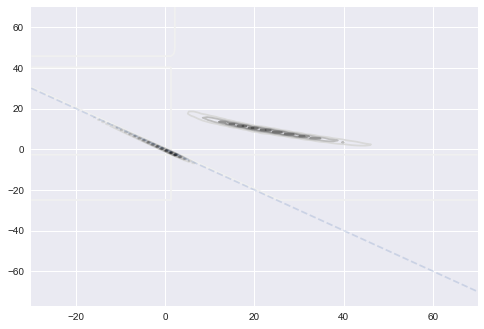

In [258]:
plt.contour(r, r, joint.value)
plt.plot(r, -r, alpha=0.2, linestyle="--")

So, we see that in the worst case, we get a probability of loss almost 4 times as bad as in the joint Gaussian case.
The density plot shows a load of mass on the x=-y line, ie bunched up _just below_ 0 (in order to register as a loss
according to our objective) and then a second mass in the positive region to make sure that the marginals and 
correlation is as expected.